In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner

from scipy.optimize import least_squares
import emcee

% matplotlib inline

## Part (a) -- fit a line to a histogram!

In [2]:
### Salpeter's data
lnM = np.array([2.23, 2.08, 1.93, 1.78, 1.63, 1.48, 1.33, 1.20, 1.09, 1.00, 0.93, 0.86, 0.8, 0.74, 0.68, 0.62, 0.56\
               , 0.5]) - 1.
lnIMF = np.array([6.63, 7.1, 7.36, 7.52, 7.72, 8., 7.98, 7.98, 8.32, 8.5, 8.6, 8.7, 8.83, 8.97, 9.04, \
                 9.13, 9.2, 9.22]) - 10.

In [3]:
def salpeter(theta, M):
    return theta[0] * M**(-theta[1])

def fun(theta, M, IMF):
    return salpeter(theta, M) - IMF

In [4]:
theta0 = np.array([1., 1.])
IMF = 10**lnIMF
M = 10**lnM

res = least_squares(fun, theta0, jac='3-point', bounds=(0, 10), args=(M, IMF), verbose=1)

`gtol` termination condition is satisfied.
Function evaluations 13, initial cost 1.7734e+01, final cost 4.2674e-04, first-order optimality 6.57e-09.


In [6]:
res.x

array([ 0.03608495,  1.40746679])

So if we fit all the data points, then we get the best fit amplitude is 0.04 and the index is 1.41.

But for whatever reason, Salpeter ignores the 3 points in the middle and only considers the range $\log(m)$ between -0.4 and 1.

So let's also do that and see what we get.

In [35]:
theta2 = np.array([1., 1.])
lnM2 = np.append(lnM[2:5],lnM[8:])
lnIMF2 = np.append(lnIMF[2:5],lnIMF[8:])
IMF2 = 10**(lnIMF2)
M2 = 10**(lnM2)

res2 = least_squares(fun, theta2, jac='3-point', bounds=(0, 10), args=(M2, IMF2), verbose=1)

`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 1.7379e+01, final cost 3.7260e-04, first-order optimality 1.60e-07.


In [36]:
res2.x

array([ 0.03705135,  1.37995148])

So now we get that the amplitude is 0.04 and the index is 1.38. Still not equal to what Salpeter reports.

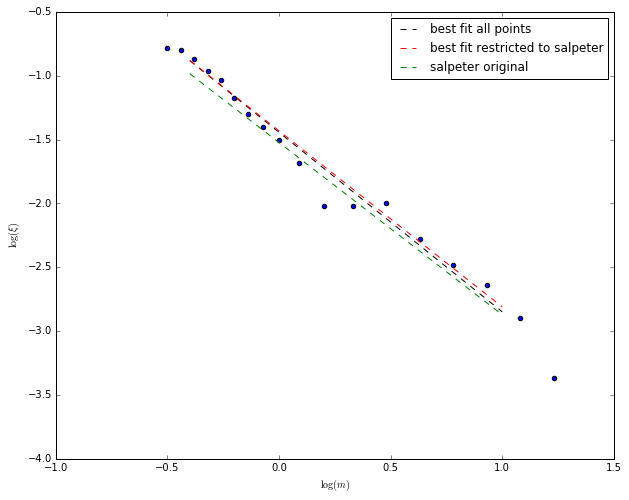

In [21]:
x = np.linspace(-0.4,1., 100)
y = salpeter(res.x, 10**x)
y2 = salpeter(res2.x, 10**x)
y3 = salpeter([0.03, 1.35], 10**x)

fig = plt.figure(figsize=(10,8))
plt.scatter(lnM, lnIMF)
plt.plot(x, np.log10(y), c='k', ls='--', label='best fit all points')
plt.plot(x, np.log10(y2), c='r', ls='--', label='best fit restricted to salpeter')
plt.plot(x, np.log10(y3), c='g', ls = '--', label='salpeter original')
plt.legend()
plt.xlabel(r'$\log(m)$')
plt.ylabel(r'$\log(\xi)$')
plt.show()


Conclusion: I have no idea what Salpeter was doing!

## Part (b)

Now we're going to use `emcee` to fit for the value of $\alpha$ from the Salpeter data. But I'm very confused as to how this should be done, because we don't have actual mass samples to be able to fit a power law as for Problem 2. So I'm just going to go with trying to use `emcee` to fit a line to the data and hope for the best!

In [30]:
### probabilites for emcee here
def lnlike(theta, x, y):
    '''We don't have error bars for Salpeter's data, so I'm just going to fit for the error.
    x = lnM
    y = lnIMF'''
    m, b, err = theta
    model = m * x + b
    inv_sigma2 = 1.0/(err**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    m, b, err = theta
    if -5.0 < m < -1.0 and 0.0 < b < 5.0 and 0.0 < err < 0.5:
        return 0.0
    return -np.inf

def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [43]:
### let's run emcee
ndim, nwalkers = 3, 100
pos = [np.array([-1.35, 0.03, 0.05]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(lnM2, lnIMF2))
sampler.run_mcmc(pos, 2000);

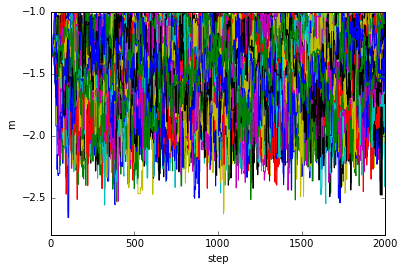

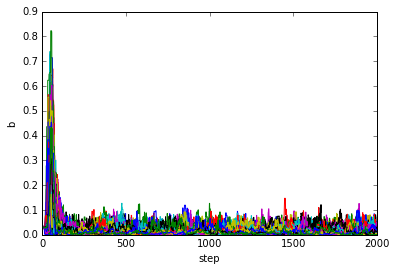

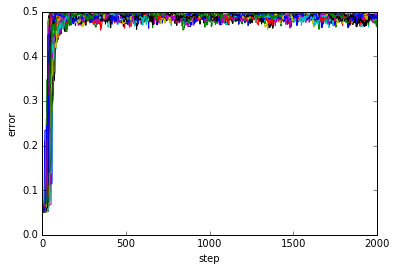

In [38]:
[plt.plot(sampler.chain[i,:,0]) for i in range(100)]
#[plt.plot(sampler.chain[i,:,0]) for i in range(sampler.chain.shape[0])]
plt.xlabel('step')
plt.ylabel(r'm')
plt.show()

[plt.plot(sampler.chain[i,:,1]) for i in range(100)]
#[plt.plot(sampler.chain[i,:,0]) for i in range(sampler.chain.shape[0])]
plt.xlabel('step')
plt.ylabel(r'b')
plt.show()

[plt.plot(sampler.chain[i,:,2]) for i in range(100)]
#[plt.plot(sampler.chain[i,:,0]) for i in range(sampler.chain.shape[0])]
plt.xlabel('step')
plt.ylabel(r'error')
plt.show()

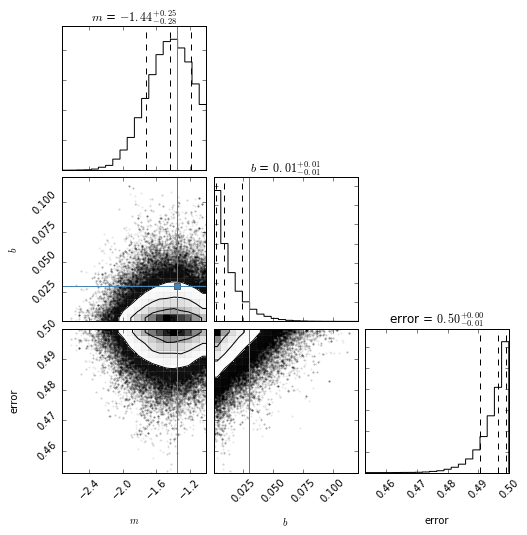

In [44]:
samples = sampler.chain[:, 250:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$", "$b$", "error"], quantiles = [0.16,0.5,0.84], show_titles=True, \
                   truths = [-1.35, 0.03, 0.0])
plt.show(fig)

Well, the result from using `emcee` is close to Salpeter and least-square fit (at least for the value of $\alpha$) if you use the points Salpeter claims to have used. 

In [45]:
### let's run emcee
ndim, nwalkers = 3, 100
pos = [np.array([-1.35, 0.03, 0.05]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(lnM, lnIMF))
sampler.run_mcmc(pos, 2000);

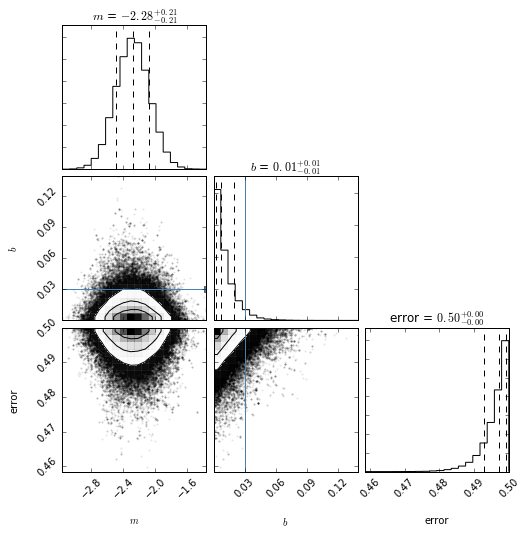

In [46]:
samples = sampler.chain[:, 250:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$", "$b$", "error"], quantiles = [0.16,0.5,0.84], show_titles=True,\
                   truths = [-1.35, 0.03, 0.0])
plt.show(fig)

If you use all of the points, then the value of $\alpha$ is quite different from Salpeter and the least squares fit.